In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

def get_dataset(encoded_text, batch_size=128, sequence_length=20):
    sequences = []
    targets = []
    for i in range(0, len(encoded_text) - sequence_length):
        seq = encoded_text[i:i+sequence_length]
        target = encoded_text[i+sequence_length]
        sequences.append(seq)
        targets.append(target)

    # Convert lists to PyTorch tensors

    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    dataset = CharDataset(sequences, targets)

    # Step 4: Create data loaders
    batch_size = 128
    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

    return train_loader, test_loader

In [4]:
# Defining the Transformer model
import torch.nn as nn
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output

In [7]:
def train(model, train_loader, test_loader, epochs, learning_rate, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracys = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)

        with torch.no_grad():
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
            val_loss = val_loss / len(test_loader)
            val_losses.append(val_loss)
            val_accuracy = correct / total
            val_accuracys.append(val_accuracy)
        if (epoch+1) % 1 == 0:
            print(f"Epoch: {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracy}")
    
    return train_losses, val_losses, val_accuracys

def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length, device='cuda'):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)

        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_losses_and_accuracy(train_losses, val_losses, val_accuracys):

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.show()

    plt.plot(val_accuracys, label='Val Accuracy')
    plt.legend()
    plt.show()



In [15]:
import time
def get_results(hidden_size=128, sequence_length=20, num_layers=2, nhead=2, device='cuda', batch_size=128, epochs=1, learning_rate=0.001):


    train_loader, test_loader = get_dataset(encoded_text, batch_size=batch_size, sequence_length=sequence_length)
    
    model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
    time_1 = time.time()
    train_losses, val_losses, val_accuracys = train(model, train_loader, test_loader, epochs, learning_rate, device)
    time_2 = time.time()

    # Plotting the losses and accuracy
    figure, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracys, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # target_str =  "This is a simple example to demonstrate how to predict the next char"
    # predicted_results = []
    # for i in range(50):
        # if predicted_results:
            # target_str = target_str + predicted_results[-1]
        # predicted_results.append(predict_next_char(model, char_to_int, int_to_char, target_str, max_length, device))
    
    print("==========================================resutls==========================================")
    # print(f'model type: {}, hidden size: {hidden_size}')
    print(f'final training loss: {train_losses[-1]}, final validation loss: {val_losses[-1]}, final validation accuracy: {val_accuracys[-1]}')
    # print(f'results:{target_str}')
    print(f'Average running time" {(time_2 - time_1)/ epochs}')
    print(f'model complexity(number of parameters): {count_parameters(model)}')
    print("===========================================================================================")
    # return train_losses, val_losses, val_accuracys


Epoch: 1, Train Loss: 2.5147782626059025, Val Loss: 2.490093911849967, Val Accuracy: 0.26273674773058386
Epoch: 2, Train Loss: 2.485104707794769, Val Loss: 2.4769811141921814, Val Accuracy: 0.2680443796929284
Epoch: 3, Train Loss: 2.4780513829563926, Val Loss: 2.475950584012205, Val Accuracy: 0.26764092793903393
Epoch: 4, Train Loss: 2.4743399649123248, Val Loss: 2.4733135693386514, Val Accuracy: 0.26898576711868205
Epoch: 5, Train Loss: 2.471703349381292, Val Loss: 2.471510786197682, Val Accuracy: 0.26997198251709065
Epoch: 6, Train Loss: 2.4699900578440297, Val Loss: 2.469192524853617, Val Accuracy: 0.2694654264260899
Epoch: 7, Train Loss: 2.46867617730498, Val Loss: 2.468581162713686, Val Accuracy: 0.2666322985542979
Epoch: 8, Train Loss: 2.4675932896937436, Val Loss: 2.4675667857686063, Val Accuracy: 0.2685061078112742
Epoch: 9, Train Loss: 2.467021744721796, Val Loss: 2.4661961559310974, Val Accuracy: 0.26913818222570884
Epoch: 10, Train Loss: 2.466160717601415, Val Loss: 2.465341

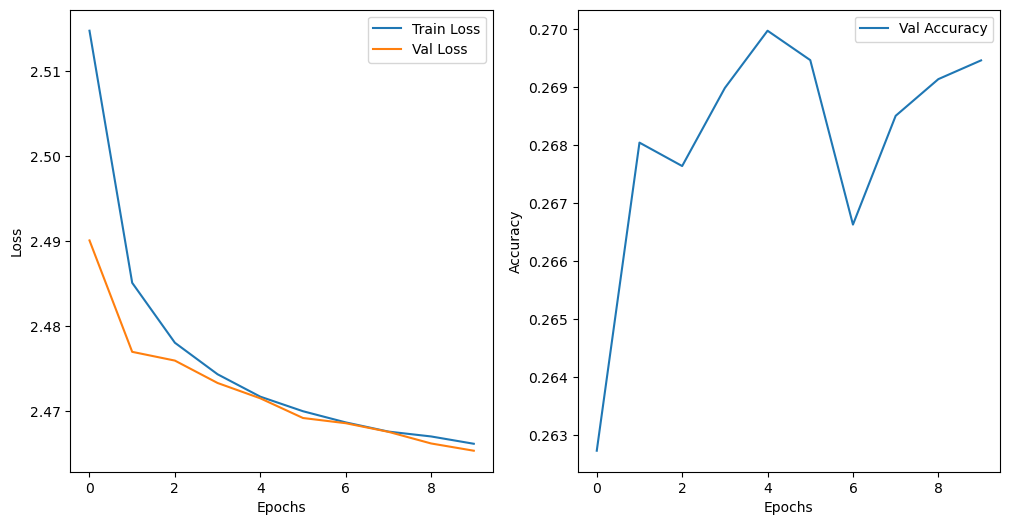

==========================================resutls==========================================
final training loss: 2.466160717601415, final validation loss: 2.465341734598918, final validation accuracy: 0.2694609436288244
Average running time" 28.82608997821808
model complexity(number of parameters): 1202753


In [19]:
get_results(hidden_size=128, sequence_length=20, num_layers=2, nhead=2, device='cuda', batch_size=128, epochs=10, learning_rate=0.001)

Epoch: 1, Train Loss: 2.5139322841707754, Val Loss: 2.4935368821324113, Val Accuracy: 0.26455465251285454
Epoch: 2, Train Loss: 2.4845346357722566, Val Loss: 2.4796108641435683, Val Accuracy: 0.2674281513226612
Epoch: 3, Train Loss: 2.477779363361639, Val Loss: 2.477856935335861, Val Accuracy: 0.26853541217448995
Epoch: 4, Train Loss: 2.4736160471462614, Val Loss: 2.4763897277812332, Val Accuracy: 0.26881334809681134
Epoch: 5, Train Loss: 2.4717088275713546, Val Loss: 2.4745821620429034, Val Accuracy: 0.26381498433248307
Epoch: 6, Train Loss: 2.4706358757432136, Val Loss: 2.4706492429482685, Val Accuracy: 0.2686250689236259
Epoch: 7, Train Loss: 2.4686981423860024, Val Loss: 2.46951608676987, Val Accuracy: 0.2695530162771828
Epoch: 8, Train Loss: 2.4676315876101187, Val Loss: 2.4677813194021025, Val Accuracy: 0.2695978446517508
Epoch: 9, Train Loss: 2.466642667388205, Val Loss: 2.467390924640859, Val Accuracy: 0.26910921536895993
Epoch: 10, Train Loss: 2.465930730737083, Val Loss: 2.46

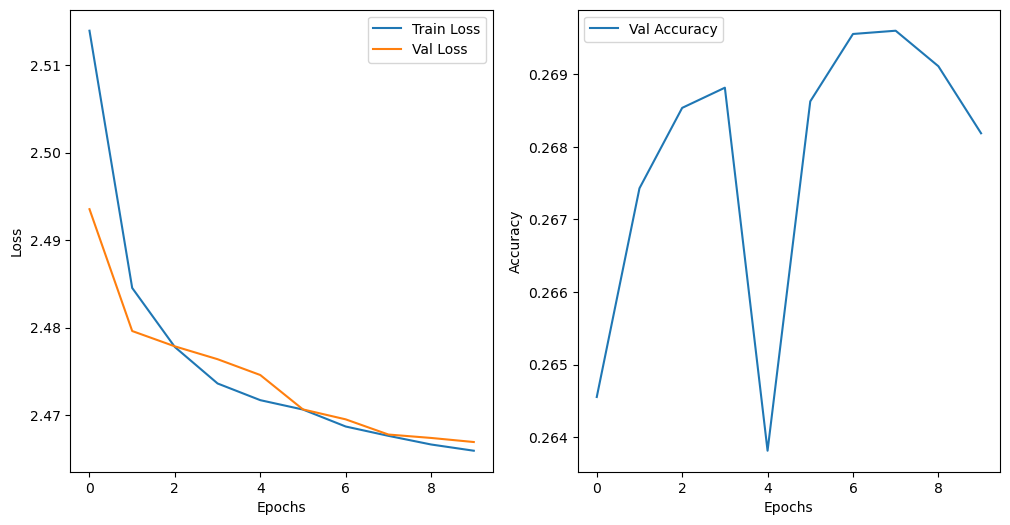

==========================================resutls==========================================
final training loss: 2.465930730737083, final validation loss: 2.4669248901833356, final validation accuracy: 0.26818575085285984
Average running time" 28.368453598022462
model complexity(number of parameters): 1202753


In [20]:
get_results(hidden_size=128, sequence_length=30, num_layers=2, nhead=2, device='cuda', batch_size=128, epochs=10, learning_rate=0.001)

## p2_2

Epoch: 1, Train Loss: 2.514099965065427, Val Loss: 2.482961967356644, Val Accuracy: 0.26751332523434035
Epoch: 2, Train Loss: 2.486705194053743, Val Loss: 2.478104859744415, Val Accuracy: 0.26791229776799524
Epoch: 3, Train Loss: 2.4800989298867004, Val Loss: 2.4748893052219865, Val Accuracy: 0.2655901879653746
Epoch: 4, Train Loss: 2.4764703736350375, Val Loss: 2.4736682430328614, Val Accuracy: 0.269328874404343
Epoch: 5, Train Loss: 2.4743296201722895, Val Loss: 2.46961431112087, Val Accuracy: 0.2693871512912813
Epoch: 6, Train Loss: 2.4725654135814565, Val Loss: 2.469870230280252, Val Accuracy: 0.26815437099066225
Epoch: 7, Train Loss: 2.471170106155737, Val Loss: 2.466721224224027, Val Accuracy: 0.2694409453407629
Epoch: 8, Train Loss: 2.4700471128941404, Val Loss: 2.4689070002073814, Val Accuracy: 0.26750884239688355
Epoch: 9, Train Loss: 2.469507222707697, Val Loss: 2.466297255941184, Val Accuracy: 0.2697412954503683
Epoch: 10, Train Loss: 2.4686493426646847, Val Loss: 2.46806748

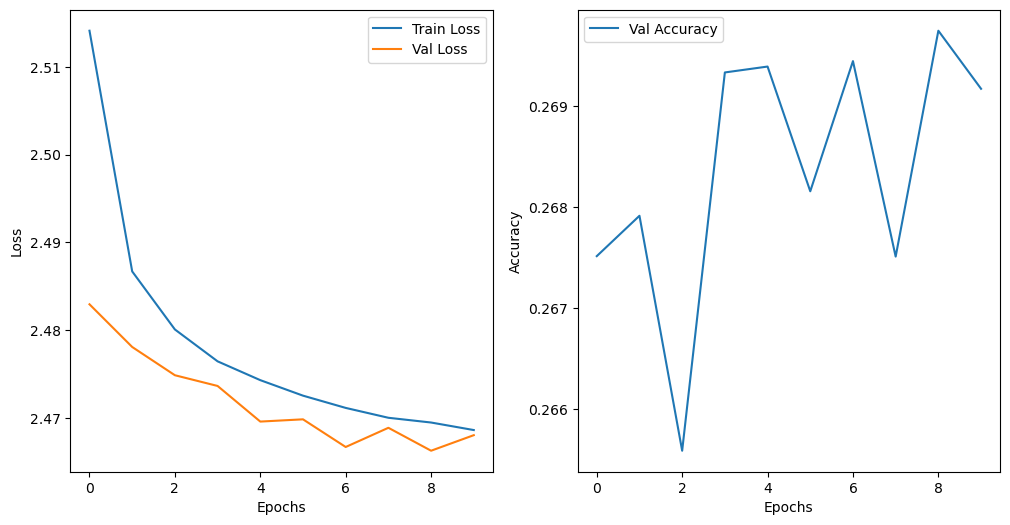

==========================================resutls==========================================
final training loss: 2.4686493426646847, final validation loss: 2.468067481746225, final validation accuracy: 0.2691674922558983
Average running time" 20.664423036575318
model complexity(number of parameters): 609729


In [21]:
get_results(hidden_size=128, sequence_length=30, num_layers=1, nhead=2, device='cuda', batch_size=128, epochs=10, learning_rate=0.001)

Epoch: 1, Train Loss: 2.52054548251581, Val Loss: 2.4877424236008716, Val Accuracy: 0.2669260735275
Epoch: 2, Train Loss: 2.490002534697949, Val Loss: 2.4773102364728867, Val Accuracy: 0.26775091561955056
Epoch: 3, Train Loss: 2.4912435257154435, Val Loss: 2.4746321768714172, Val Accuracy: 0.2666660689550058
Epoch: 4, Train Loss: 2.494713358781971, Val Loss: 2.474619557921803, Val Accuracy: 0.26724883782438935
Epoch: 5, Train Loss: 2.480526853893519, Val Loss: 2.4694525592298393, Val Accuracy: 0.26923473481775023
Epoch: 6, Train Loss: 2.485033027943153, Val Loss: 2.466300925644936, Val Accuracy: 0.2701088881218256
Epoch: 7, Train Loss: 2.5009503166906737, Val Loss: 2.46742239479901, Val Accuracy: 0.26883127944663854
Epoch: 8, Train Loss: 2.482271401449927, Val Loss: 2.465862189772754, Val Accuracy: 0.2699744029981217
Epoch: 9, Train Loss: 2.4829131756715235, Val Loss: 2.4651211057664058, Val Accuracy: 0.2701492336589368
Epoch: 10, Train Loss: 2.5050451755181715, Val Loss: 2.46618559561

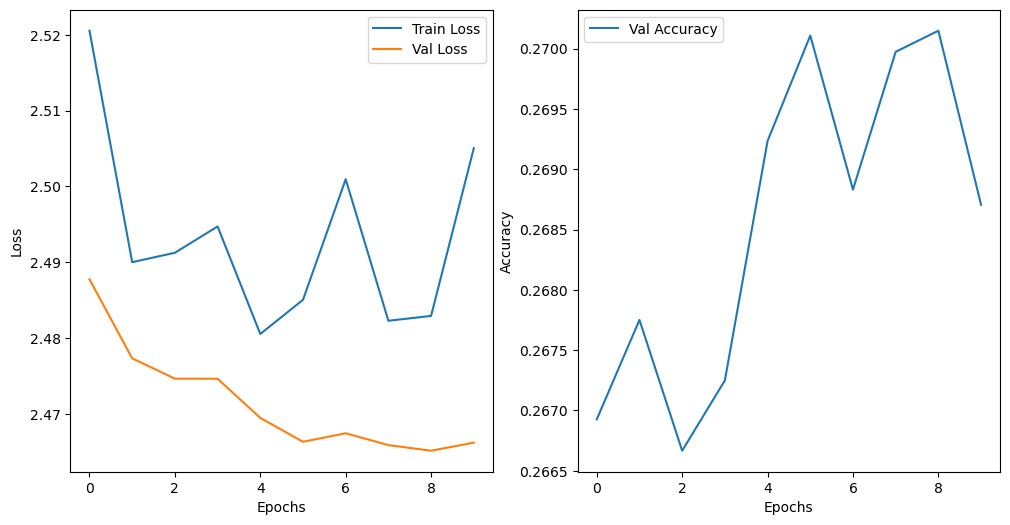

==========================================resutls==========================================
final training loss: 2.5050451755181715, final validation loss: 2.4661855956158005, final validation accuracy: 0.26870575999784824
Average running time" 45.16704568862915
model complexity(number of parameters): 2388801


In [22]:
get_results(hidden_size=128, sequence_length=30, num_layers=4, nhead=2, device='cuda', batch_size=128, epochs=10, learning_rate=0.001)

#### nhead = 4

Epoch: 1, Train Loss: 2.5156091423261735, Val Loss: 2.4808886386304496, Val Accuracy: 0.26806919707898313
Epoch: 2, Train Loss: 2.4878594163362826, Val Loss: 2.4754723478033838, Val Accuracy: 0.2688671421462929
Epoch: 3, Train Loss: 2.4813108070787178, Val Loss: 2.4692246472090056, Val Accuracy: 0.270938213051333
Epoch: 4, Train Loss: 2.4775739663712812, Val Loss: 2.4684441223680733, Val Accuracy: 0.265823295513128
Epoch: 5, Train Loss: 2.4747901942219737, Val Loss: 2.4662653813058455, Val Accuracy: 0.270938213051333
Epoch: 6, Train Loss: 2.4733384702989443, Val Loss: 2.46467109692213, Val Accuracy: 0.27111304371214806
Epoch: 7, Train Loss: 2.4718947268667675, Val Loss: 2.4631845923723055, Val Accuracy: 0.27175408946846996
Epoch: 8, Train Loss: 2.4710397010415845, Val Loss: 2.4619282833543648, Val Accuracy: 0.27274927938387883
Epoch: 9, Train Loss: 2.4701307884797377, Val Loss: 2.4644903393907924, Val Accuracy: 0.2697726753125658
Epoch: 10, Train Loss: 2.4694001666786884, Val Loss: 2.4

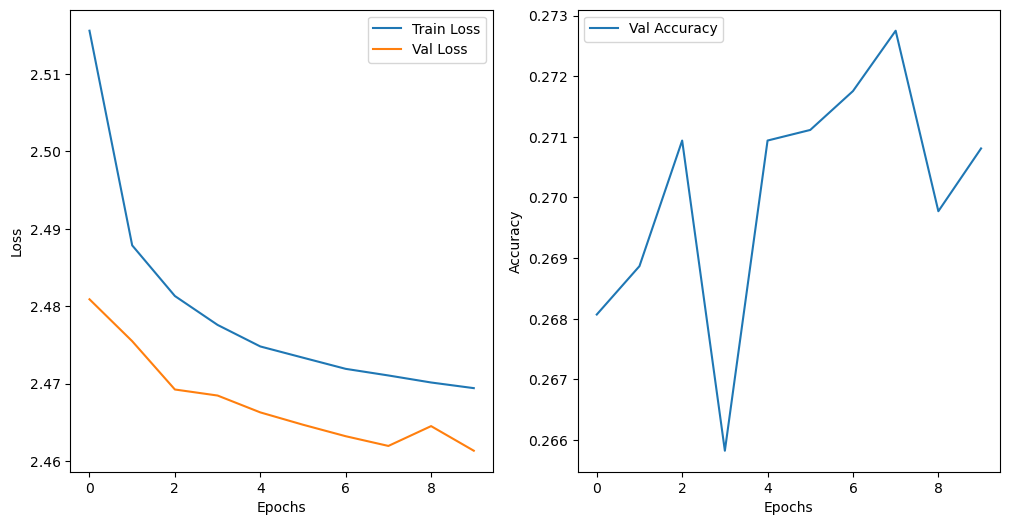

==========================================resutls==========================================
final training loss: 2.4694001666786884, final validation loss: 2.4613096827552434, final validation accuracy: 0.2708082107650859
Average running time" 19.918330669403076
model complexity(number of parameters): 609729


In [23]:
get_results(hidden_size=128, sequence_length=30, num_layers=1, nhead=4, device='cuda', batch_size=128, epochs=10, learning_rate=0.001)

Epoch: 1, Train Loss: 2.514675279868723, Val Loss: 2.4875535104579782, Val Accuracy: 0.26682745110345046
Epoch: 2, Train Loss: 2.4853692626173443, Val Loss: 2.4725375291744456, Val Accuracy: 0.2704899293056533
Epoch: 3, Train Loss: 2.478513605452377, Val Loss: 2.469325571038295, Val Accuracy: 0.27154787894545734
Epoch: 4, Train Loss: 2.4748858762279844, Val Loss: 2.4678719934210718, Val Accuracy: 0.27122063181111117
Epoch: 5, Train Loss: 2.472030514471844, Val Loss: 2.466236308464974, Val Accuracy: 0.2705975174046164
Epoch: 6, Train Loss: 2.470838028572102, Val Loss: 2.463854101014698, Val Accuracy: 0.2715702931327413
Epoch: 7, Train Loss: 2.469752603540185, Val Loss: 2.464852316791274, Val Accuracy: 0.2714492565214078
Epoch: 8, Train Loss: 2.4686027614809083, Val Loss: 2.4631000699083216, Val Accuracy: 0.27060648307953
Epoch: 9, Train Loss: 2.4677287225947597, Val Loss: 2.4639393867464223, Val Accuracy: 0.2700640597472576
Epoch: 10, Train Loss: 2.467247843571388, Val Loss: 2.462566292

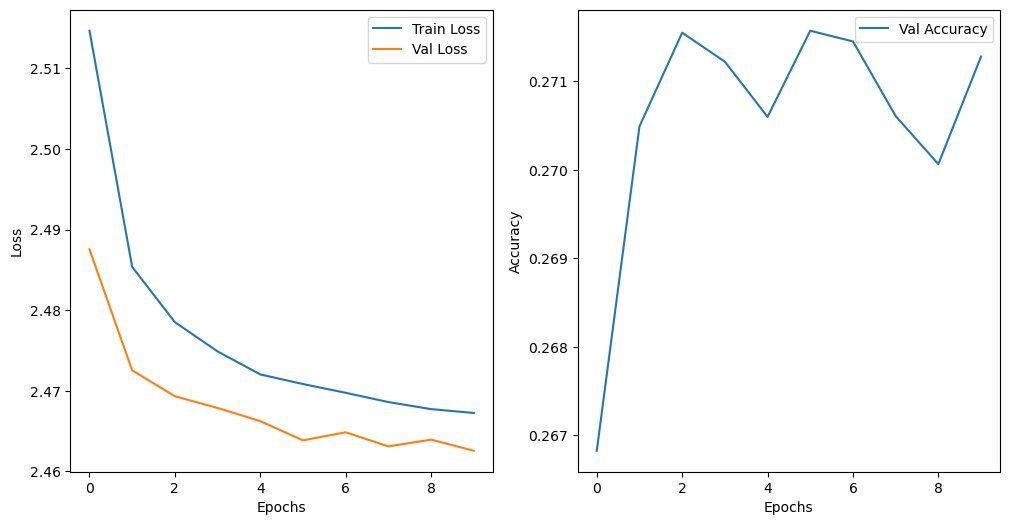

==========================================resutls==========================================
final training loss: 2.467247843571388, final validation loss: 2.462566292019186, final validation accuracy: 0.2712789086980495
Average running time" 28.0907662153244
model complexity(number of parameters): 1202753


In [24]:
get_results(hidden_size=128, sequence_length=30, num_layers=2, nhead=4, device='cuda', batch_size=128, epochs=10, learning_rate=0.001)

Epoch: 1, Train Loss: 2.5201754008841393, Val Loss: 2.486148261230565, Val Accuracy: 0.26335325207443305
Epoch: 2, Train Loss: 2.4893579082590236, Val Loss: 2.495505760267283, Val Accuracy: 0.26780022683157534
Epoch: 3, Train Loss: 2.485902616263667, Val Loss: 2.4698574277633782, Val Accuracy: 0.26762091333330346
Epoch: 4, Train Loss: 2.48105256583454, Val Loss: 2.467233198645193, Val Accuracy: 0.2703375128321222
Epoch: 5, Train Loss: 2.4818658721700046, Val Loss: 2.466647285465803, Val Accuracy: 0.2702523389204431
Epoch: 6, Train Loss: 2.483002154155497, Val Loss: 2.4675236854892453, Val Accuracy: 0.2703913068816038
Epoch: 7, Train Loss: 2.482403872516466, Val Loss: 2.468867954274942, Val Accuracy: 0.2697188812630843
Epoch: 8, Train Loss: 2.4770525752711556, Val Loss: 2.46798021657947, Val Accuracy: 0.27110407803723446
Epoch: 9, Train Loss: 2.475400640543206, Val Loss: 2.465580170549884, Val Accuracy: 0.2684995494748356
Epoch: 10, Train Loss: 2.4729898555211753, Val Loss: 2.5109652966

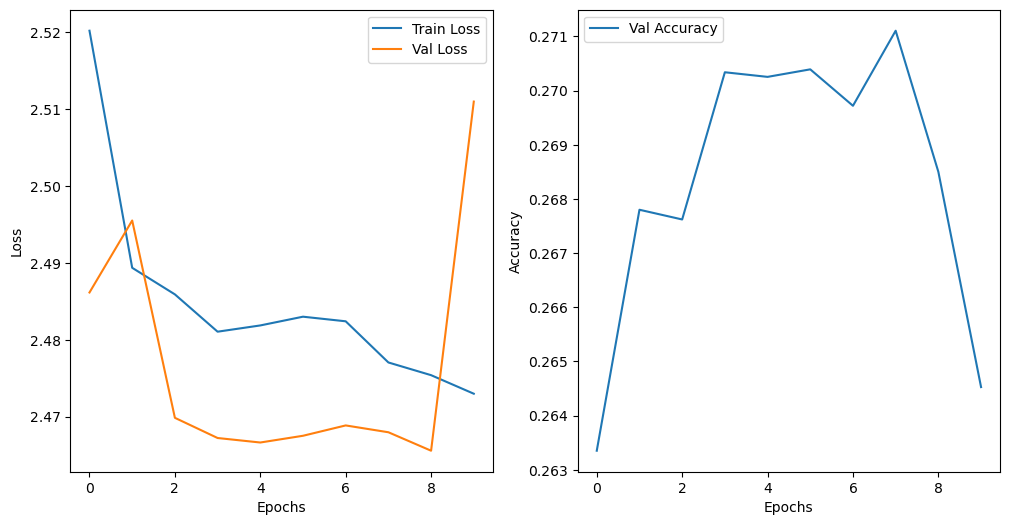

==========================================resutls==========================================
final training loss: 2.4729898555211753, final validation loss: 2.5109652966790956, final validation accuracy: 0.26452775548811375
Average running time" 46.607939791679385
model complexity(number of parameters): 2388801


In [25]:
get_results(hidden_size=128, sequence_length=30, num_layers=4, nhead=4, device='cuda', batch_size=128, epochs=10, learning_rate=0.001)

### seq = 50

Epoch: 1, Train Loss: 2.515139392759208, Val Loss: 2.486368884591624, Val Accuracy: 0.2585926327728192
Epoch: 2, Train Loss: 2.4862726784012374, Val Loss: 2.4755608224348986, Val Accuracy: 0.2666439532162694
Epoch: 3, Train Loss: 2.479000482099536, Val Loss: 2.4713271037641777, Val Accuracy: 0.26848194953131094
Epoch: 4, Train Loss: 2.475168315500017, Val Loss: 2.468210128826857, Val Accuracy: 0.2679708968973726
Epoch: 5, Train Loss: 2.4728595621530096, Val Loss: 2.4662308750382387, Val Accuracy: 0.26861643706655786
Epoch: 6, Train Loss: 2.4717225378614094, Val Loss: 2.4646194260214775, Val Accuracy: 0.2692261138930107
Epoch: 7, Train Loss: 2.4695050013559547, Val Loss: 2.4652843463031027, Val Accuracy: 0.2684998812026772
Epoch: 8, Train Loss: 2.4683616022830406, Val Loss: 2.4642990748908282, Val Accuracy: 0.2678991702119075
Epoch: 9, Train Loss: 2.4676085294122387, Val Loss: 2.4656871129778426, Val Accuracy: 0.26916783596107036
Epoch: 10, Train Loss: 2.4673608803301046, Val Loss: 2.46

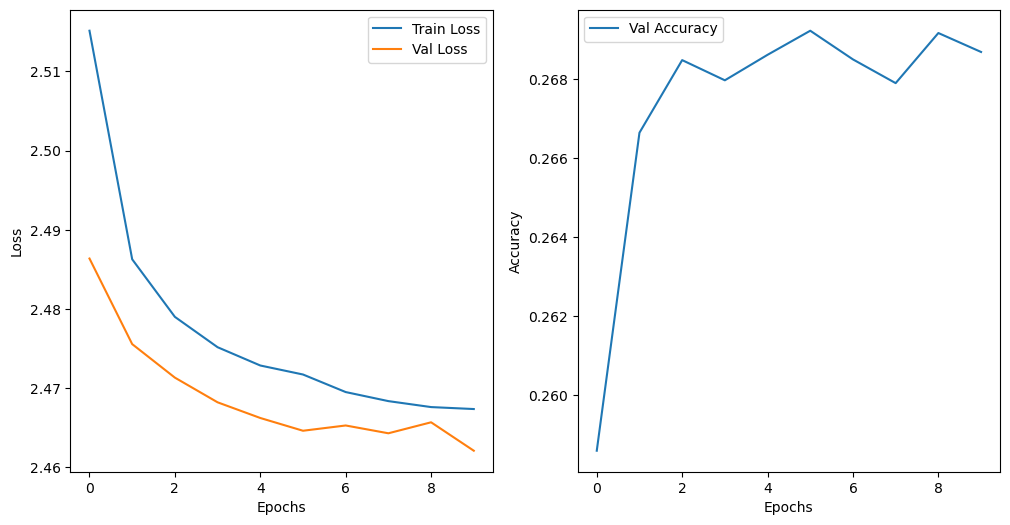

==========================================resutls==========================================
final training loss: 2.4673608803301046, final validation loss: 2.4620967500865016, final validation accuracy: 0.2686881637520229
Average running time" 36.875700283050534
model complexity(number of parameters): 1202753


In [26]:
get_results(hidden_size=128, sequence_length=50, num_layers=2, nhead=2, device='cuda', batch_size=128, epochs=10, learning_rate=0.001)